<a href="https://colab.research.google.com/github/duncansnh/burn-mapping/blob/region_growing/CUU_burn_extent_image_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Script to threshold an input image based on one or more index thresholds
Inputs are

1)  indices generated from sentinel 2 imagery (generated from previous script) 

Main steps:
•	threshold the image

Duncan Blake NatureScot 30 September 2020

Changes 13 November 2020: 

Extra code to create a second thresholding layer to test whether this is a viable alternative to region growing

In [2]:
#This is only required if running in colab notebook to install the libraries
#If running Python code elsewhere need to make sure below libraries are installed
! pip install geopandas
! pip install descartes
! pip install rasterio
! pip install rasterstats

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import geopandas as gpd
import descartes
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.features import sieve, shapes
from shapely.geometry import mapping
from rasterstats import zonal_stats
import gdal

/usr/local/lib/python3.6/dist-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


In [4]:
#Only if running in Google Colab, in which case input image, training polygons and output results need to be in Google Drive.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Set working drive, file paths and dataset name parameters


In [5]:

wd = '/content/drive/My Drive'
image_dir = os.path.join(wd, 'Imagery')
plot_dir = os.path.join(wd, 'Plots')

# Cairngorms parameters
image = 'CUU_burn_cairngorms_indices.tif'
outImage = 'CUU_burn_cairngorms_core_burns.tif'

# Skye parameters
# image = 'CUU_burn_skye_indices.tif'
# outImage = 'CUU_burn_skye_core_burns.tif'

###Open input image and polygon dataset

In [6]:
# Read image
s2 = rasterio.open(os.path.join(image_dir,image))
print(s2.shape)
profile = s2.profile.copy()
# optionally check all ok by showing dsavi layer
# plt.imshow(s2.read(21), cmap='pink')
# plt.show()
# print(type(s2))

(884, 1343)


## Import pickled dataframe and determine threshold values from percentiles


In [9]:
# read in pickled object of all data combined (created from previous script that generated the boxplots)
pickleName = ("All_data_for_thresholding.pkl")
df_all_data = pd.read_pickle(os.path.join(plot_dir,pickleName))

# obtain percentile values
# isolate burn rows in dataframe
df_burns = df_all_data[df_all_data.Class == "Burns"]
# subset columns we are interested in
df_burns_indices = df_burns[['dnbr','dnbr2','dcsi','dsavi','postnbr']]
# extract quartile statistics needed

# medians
print("medians")
dNBRQ2 = df_burns_indices.dnbr.quantile(0.5)
print(dNBRQ2)
dSAVIQ2 = df_burns_indices.dsavi.quantile(0.5)
print(dSAVIQ2)
postNBRQ2 = df_burns_indices.postnbr.quantile(0.5)
print(postNBRQ2)

# 75th percentile
print("75th percentiles")
dNBRQ3 = df_burns_indices.dnbr.quantile(0.75)
print(dNBRQ3)
dSAVIQ3 = df_burns_indices.dsavi.quantile(0.75)
print(dSAVIQ3)
postNBRQ3 = df_burns_indices.postnbr.quantile(0.75)
print(postNBRQ3)
dNBR2Q3 = df_burns_indices.dnbr2.quantile(0.75)
print(dNBR2Q3)

# 25th percentile for extended areas
print("25th percentiles")
dSAVIQ1 = df_burns_indices.dsavi.quantile(0.25)
print(dSAVIQ1)
postNBRQ1 = df_burns_indices.postnbr.quantile(0.25)
print(postNBRQ1)

medians
0.214064359664917
0.2852725386619568
0.23950617015361786
75th percentiles
0.2735748812556267
0.3618958219885826
0.2981530427932739
0.1445029228925705
25th percentiles
0.20674878358840942
0.17344753444194794


## Set the threshold


In [10]:
# for multiple indices threshold
# read in bands required 2 postnbr; 3 dnbr; 6 dnbr2; 15 dcsi; 21 dsavi 
indicesArray = s2.read([2,3,6,15,21])

# read in a single band as a template for the output reclassified image containing core burn pixels
band1 = s2.read(1)
reclassArray = band1.copy()
# reset all values in output raster to 0 as otherwise pixel values not reclassed by the condition below may retain value from prenbr (band1)
reclassArray[np.where(reclassArray != 0)] = 0

# set up second array to hold extended burn area
extendArray = np.copy(reclassArray)

# reclassify the array to contain core burn pixels
# in this case where dsavi is greater than the median and post fire image NBR is greater than the median 
reclassArray[np.where((indicesArray[4]>=dSAVIQ2) & (indicesArray[0]>=postNBRQ2))] = 1 
# then attempt to solve issue of edges of clouds being falsely identified which have high values in dnbr2
reclassArray[np.where(indicesArray[2]>=0.8)] = 0

# rasterio function to exclude clumps of pixels smaller than 3.  Diagonally joined pixels are allowed.
sievedArray = sieve(reclassArray.astype(rasterio.uint8), size=3, connectivity=8)

# reclassify the second array to contain extended burn pixels
# in this case where dsavi is greater than the median and post fire image NBR is greater than the median 
extendArray[np.where(indicesArray[4]>=dSAVIQ1)] = 1 

# rasterio function to exclude clumps of pixels smaller than 3.  Diagonally joined pixels are allowed.
sievedExtendArray = sieve(extendArray.astype(rasterio.uint8), size=3, connectivity=8)

## Plot the thresholded rasters

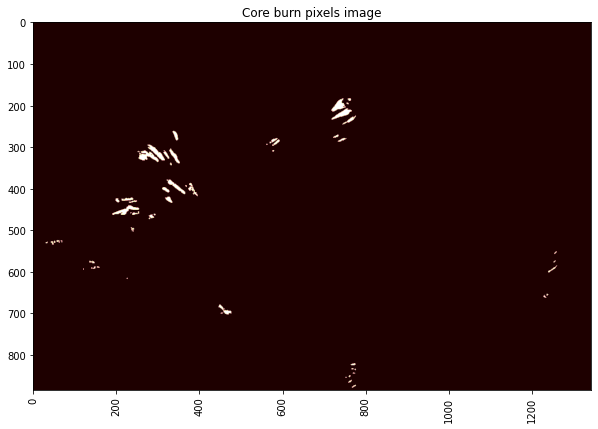

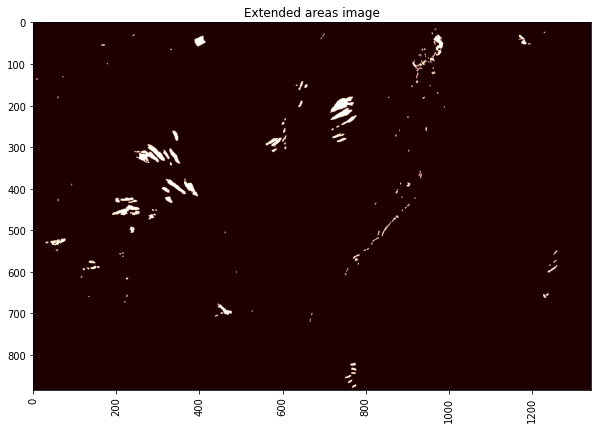

In [12]:
# an inital look to see if in the right ballpark but viewing in GIS is much better!
plt.figure(figsize=(10,8)); 
plt.imshow(sievedArray,cmap='pink')
plt.title('Core burn pixels image')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

plt.figure(figsize=(10,8)); 
plt.imshow(sievedExtendArray,cmap='pink')
plt.title('Extended areas image')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees


## Export the thresholded raster

In [ ]:
# export the classified array, converting to an integer
profile.update(dtype=rasterio.uint8,
        count=1,
        compress='lzw')  

with rasterio.open(os.path.join(image_dir,outImage), 'w', **profile) as dst:
        dst.write(sievedArray, 1)